<h1 style='text-align: center;'>Hotel Booking Demand: Part 2</h1>
<h5 style='text-align: center;'>Created by: Umam Ihsanil Ummah & Garudapaksi Yusuf</h5>

In [1]:
# Importing libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
from phik import phik_matrix

# Loading cleaned dataset
data = pd.read_csv(filepath_or_buffer='hotel_bookings_cleaned.csv')

---

# **Data Preprocessing**

## Correlation

In [2]:
# ...
numerical_target_vars = data.select_dtypes(include='number').drop(columns=['total_stays_in_nights', 'total_guests', 'revenue'])

# ...
plt.rcParams["image.cmap"] = 'YlGnBu'

# Computing pairwise correlation of numerical variables
numerical_target_vars.corr(method='spearman', # Using Spearman's method for non-parametric variables
                           numeric_only=True)\
                     .style.background_gradient(cmap=None).format(formatter='{:.3f}') # Adding colors & rounding numbers displayed

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000,0.225,0.087,-0.000,0.005,0.059,0.095,0.089,0.061,-0.021,-0.090,0.126,-0.101,-0.125,0.015,0.141,-0.186,-0.129
lead_time,0.225,1.000,0.136,0.097,0.012,0.292,0.415,0.228,0.050,-0.002,-0.220,0.000,-0.191,0.056,0.098,0.101,-0.110,0.061
arrival_date_year,0.087,0.136,1.000,-0.516,-0.011,0.009,0.018,0.058,0.043,-0.023,0.023,-0.109,0.033,-0.005,-0.029,0.189,-0.041,0.066
arrival_date_week_number,-0.000,0.097,-0.516,1.000,0.088,0.036,0.041,0.025,0.017,0.017,-0.039,0.047,-0.047,0.018,-0.000,0.114,0.010,0.044
arrival_date_day_of_month,0.005,0.012,-0.011,0.088,1.000,-0.009,-0.017,0.003,0.017,0.000,-0.004,-0.004,-0.001,0.005,0.012,0.019,0.008,-0.003
stays_in_weekend_nights,0.059,0.292,0.009,0.036,-0.009,1.000,0.326,0.128,0.035,0.018,-0.121,-0.028,-0.108,0.021,-0.039,0.044,-0.044,0.035
stays_in_week_nights,0.095,0.415,0.018,0.041,-0.017,0.326,1.000,0.170,0.045,0.024,-0.150,-0.031,-0.135,0.051,0.006,0.081,-0.051,0.054
adults,0.089,0.228,0.058,0.025,0.003,0.128,0.170,1.000,0.068,0.027,-0.219,-0.087,-0.238,-0.075,-0.034,0.335,0.013,0.157
children,0.061,0.050,0.043,0.017,0.017,0.035,0.045,0.068,1.000,0.032,-0.049,-0.030,-0.050,0.047,-0.029,0.284,0.041,0.055
babies,-0.021,-0.002,-0.023,0.017,0.000,0.018,0.024,0.027,0.032,1.000,-0.014,-0.007,-0.016,0.117,-0.007,0.021,0.033,0.092


Notes:
* Unused columns are...
* If there are no repeated/duplicated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone (linear) function of the other. If Y variable tends to increase when X variable increases, the Spearman correlation coefficient is positive —and vice versa for negative coefficient.
* Pairing of variables with moderate to high positive correlation value (0.33 - 1) are:
    * `is_repeated_guest` & `previous_bookings_not_canceled`
    * `previous_cancellations` & `previous_bookings_not_canceled`

Correlated variables provide redundant information and reducing prediction model's ability to generalize (causing overfitting). Therefore, **variable which causes this correlation will not be used: `previous_bookings_not_canceled`**.

* adults - adr = 0.34  
    * moderately correlated?  
    * which one to drop? adr?
    * total_guests = medium - high correlation with others
* arrival_date_week_number = drop
* lead_time - stays_in_week_nights?
    * total_stays = also medium - high?

In [3]:
# Selecting categorical variables as subset
categorical_target_vars = data.select_dtypes(include='object')\
                              .combine_first(other=data[['is_canceled']]) # Combining subset with target variable

# Computing pairwise correlation of categorical & target variables
phik_matrix(df=categorical_target_vars, 
            # Applying target as interval column/variable
            interval_cols='is_canceled')\
            .style.background_gradient(cmap=None).format(formatter='{:.3f}')

,arrival_date_month,assigned_room_type,country,customer_type,deposit_type,distribution_channel,hotel,is_canceled,market_segment,meal,reservation_status,reservation_status_date,reserved_room_type
arrival_date_month,1.000,0.095,0.262,0.213,0.114,0.125,0.076,0.108,0.168,0.147,0.151,0.977,0.110
assigned_room_type,0.095,1.000,0.139,0.175,0.135,0.146,0.477,0.120,0.171,0.346,0.148,0.219,0.940
country,0.262,0.139,1.000,0.230,0.226,0.316,0.445,0.235,0.401,0.232,0.322,0.505,0.163
customer_type,0.213,0.175,0.230,1.000,0.053,0.111,0.094,0.193,0.453,0.194,0.097,0.493,0.152
deposit_type,0.114,0.135,0.226,0.053,1.000,0.049,0.034,0.100,0.304,0.034,0.342,0.581,0.081
distribution_channel,0.125,0.146,0.316,0.111,0.049,1.000,0.111,0.123,0.772,0.115,0.147,0.333,0.224
hotel,0.076,0.477,0.445,0.094,0.034,0.111,1.000,0.108,0.164,0.467,0.043,0.260,0.408
is_canceled,0.108,0.120,0.235,0.193,0.100,0.123,0.108,1.000,0.206,0.082,1.000,0.367,0.072
market_segment,0.168,0.171,0.401,0.453,0.304,0.772,0.164,0.206,1.000,0.231,0.234,0.477,0.210
meal,0.147,0.346,0.232,0.194,0.034,0.115,0.467,0.082,0.231,1.000,0.043,0.321,0.253


Notes:
* Phi_K (ϕk) library is used to compute correlation between categorical and interval variables.
    * Based on Pearson's chi-squared contingency test —a hypothesis test for independence between two or more variables.
    * `is_canceled` is added into this analysis because we would want to find the association between categorical variables and the target of this prediction model, and also applied as interval variable because the difference between values in this column (`1` or `0`) is meaningful.
    * Phi_K correlation matrix drops missing value from the data to calculate the correlation coefficient by default (parameter `dropna` already set to `True`).
    * It captures any non-linear relationship between variables, and has a built-in noise reduction against statistical fluctuations or outliers (parameter `noise_correction` also set to `True` by default).
    * Correlation coefficient value is between 0 and 1, hence no indication of relationship direction between variables.
* There are plenty of variable pairings with moderate to high correlation value (ϕk value of 0.33 - 1).
    * First step of this analysis segment will drop correlated variables with target `is_canceled`:
        * `reservation_status` (ϕk = `1.000`; perfectly correlated)
        * `reservation_status_date` (ϕk = `0.367`; medium correlation)

In [4]:
# Dropping variables correlated with target
categorical_target_vars.drop(columns=['reservation_status', 'reservation_status_date'], inplace=True)

# Verifying process
phik_matrix(df=categorical_target_vars, interval_cols='is_canceled').style.background_gradient(cmap=None).format(formatter='{:.3f}')

,arrival_date_month,assigned_room_type,country,customer_type,deposit_type,distribution_channel,hotel,is_canceled,market_segment,meal,reserved_room_type
arrival_date_month,1.000,0.095,0.262,0.213,0.114,0.125,0.076,0.108,0.168,0.147,0.110
assigned_room_type,0.095,1.000,0.139,0.175,0.135,0.146,0.477,0.120,0.171,0.346,0.940
country,0.262,0.139,1.000,0.230,0.226,0.316,0.445,0.235,0.401,0.232,0.163
customer_type,0.213,0.175,0.230,1.000,0.053,0.111,0.094,0.193,0.453,0.194,0.152
deposit_type,0.114,0.135,0.226,0.053,1.000,0.049,0.034,0.100,0.304,0.034,0.081
distribution_channel,0.125,0.146,0.316,0.111,0.049,1.000,0.111,0.123,0.772,0.115,0.224
hotel,0.076,0.477,0.445,0.094,0.034,0.111,1.000,0.108,0.164,0.467,0.408
is_canceled,0.108,0.120,0.235,0.193,0.100,0.123,0.108,1.000,0.206,0.082,0.072
market_segment,0.168,0.171,0.401,0.453,0.304,0.772,0.164,0.206,1.000,0.231,0.210
meal,0.147,0.346,0.232,0.194,0.034,0.115,0.467,0.082,0.231,1.000,0.253


Notes:
* Number of pairings of variables with moderate-high correlation value are listed below:
    * `hotel`: 4 pairings
    * `assigned_room_type` and `market_segment`: 3 pairings
    * `country`, `meal`, and `reserved_room_type`: 2 pairings
    * `customer_type` and `distribution_channel`: 1 pairing
* To reduce this number, the second step of this segment will iterate to drop these variables, starting from the top (highest number of pairings).

In [5]:
# Dropping top 3 variables with the highest amount of correlation pairings
categorical_target_vars.drop(columns=['hotel', 'assigned_room_type', 'market_segment'], inplace=True)

# Verifying process
phik_matrix(df=categorical_target_vars, interval_cols='is_canceled').style.background_gradient(cmap=None).format(formatter='{:.3f}')

,arrival_date_month,country,customer_type,deposit_type,distribution_channel,is_canceled,meal,reserved_room_type
arrival_date_month,1.000,0.262,0.213,0.114,0.125,0.108,0.147,0.110
country,0.262,1.000,0.230,0.226,0.316,0.235,0.232,0.163
customer_type,0.213,0.230,1.000,0.053,0.111,0.193,0.194,0.152
deposit_type,0.114,0.226,0.053,1.000,0.049,0.100,0.034,0.081
distribution_channel,0.125,0.316,0.111,0.049,1.000,0.123,0.115,0.224
is_canceled,0.108,0.235,0.193,0.100,0.123,1.000,0.082,0.072
meal,0.147,0.232,0.194,0.034,0.115,0.082,1.000,0.253
reserved_room_type,0.110,0.163,0.152,0.081,0.224,0.072,0.253,1.000


Notes:

* Experimenting to drop only `hotel` still leaves `assigned_room_type` and `market_segment` as variable pairings with moderate-high correlation value.
    * After dropping `assigned_room_type`, and `market_segment`, no more variable pairing with medium-high correlation value detected.
* **These categorical variables (excluding `is_canceled`) will be the features used in prediction modeling**.

In [6]:
# Assigning dataframe from non-correlated variables
df = numerical_target_vars.join(other=categorical_target_vars.drop(columns='is_canceled'))

# Showing dataframe sample
with pd.option_context('display.max_columns', None):
    display(df.sample(n=10))

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month,country,customer_type,deposit_type,distribution_channel,meal,reserved_room_type
68166,0,192,2016,37,5,1,3,2,0,0,0,0,0,0,0,107.10,0,2,September,POL,Transient,No Deposit,TA/TO,BB,A
54966,0,24,2015,46,8,2,0,1,0,0,0,0,0,0,0,101.00,0,1,November,PRT,Contract,No Deposit,TA/TO,BB,A
77898,0,214,2017,13,26,2,2,2,0,0,0,0,0,0,0,88.40,0,2,March,DEU,Transient,No Deposit,TA/TO,BB,A
24161,0,72,2016,45,31,1,1,2,0,0,0,0,0,3,0,43.80,1,1,October,PRT,Transient,No Deposit,TA/TO,BB,A
45139,1,88,2016,51,17,2,5,3,0,0,0,0,0,2,0,119.00,0,1,December,USA,Transient,No Deposit,TA/TO,BB,D
32648,0,143,2017,31,3,2,5,2,0,0,0,0,0,0,0,175.50,0,1,August,GBR,Contract,No Deposit,TA/TO,SC,D
46077,1,9,2017,5,1,8,19,2,0,0,0,0,0,0,0,99.29,0,0,February,GBR,Transient,No Deposit,TA/TO,BB,D
22000,0,85,2016,34,19,2,3,1,1,0,0,0,0,2,0,283.00,0,0,August,PRT,Transient,No Deposit,Direct,FB,E
74397,0,18,2017,2,8,2,2,2,0,0,0,0,0,0,0,108.38,0,2,January,DEU,Transient,No Deposit,TA/TO,BB,E
85743,0,0,2017,32,12,0,1,2,0,0,1,0,0,1,0,240.00,0,2,August,FRA,Transient,No Deposit,Direct,HB,D


In [7]:
# Detecting duplicated data (after subsetting variables)
df[df.duplicated()]

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month,country,customer_type,deposit_type,distribution_channel,meal,reserved_room_type
403,0,57,2015,29,15,0,2,2,0,0,...,107.00,0,0,July,PRT,Transient-Party,No Deposit,Direct,FB,A
406,0,57,2015,29,15,0,2,2,0,0,...,107.00,0,0,July,PRT,Transient,No Deposit,Direct,FB,A
411,0,57,2015,29,15,0,2,1,0,0,...,94.00,0,0,July,PRT,Transient-Party,No Deposit,Direct,FB,A
1296,1,57,2015,35,27,1,3,2,0,1,...,133.00,0,1,August,PRT,Transient,No Deposit,TA/TO,HB,A
1912,1,81,2015,40,27,2,5,2,0,0,...,66.29,0,0,September,PRT,Transient,No Deposit,TA/TO,BB,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86337,0,176,2017,34,21,1,1,2,0,0,...,135.00,0,1,August,DEU,Transient,No Deposit,Direct,HB,A
86483,0,142,2017,34,24,0,1,2,0,0,...,150.00,0,2,August,USA,Transient,No Deposit,Direct,BB,D
86581,0,457,2017,34,25,0,2,2,0,0,...,122.40,0,1,August,DEU,Transient-Party,No Deposit,TA/TO,HB,A
86836,0,213,2017,35,28,1,3,1,0,0,...,104.00,0,0,August,PRT,Transient-Party,No Deposit,TA/TO,HB,A


Notes:
* subset variables may cause duplication
* same with previous section, drop to avoid overfitting

In [8]:
# Handling duplicated data
df.drop_duplicates()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month,country,customer_type,deposit_type,distribution_channel,meal,reserved_room_type
0,0,342,2015,27,1,0,0,2,0,0,...,0.00,0,0,July,PRT,Transient,No Deposit,Direct,BB,C
1,0,737,2015,27,1,0,0,2,0,0,...,0.00,0,0,July,PRT,Transient,No Deposit,Direct,BB,C
2,0,7,2015,27,1,0,1,1,0,0,...,75.00,0,0,July,GBR,Transient,No Deposit,Direct,BB,A
3,0,13,2015,27,1,0,1,1,0,0,...,75.00,0,0,July,GBR,Transient,No Deposit,Corporate,BB,A
4,0,14,2015,27,1,0,2,2,0,0,...,98.00,0,1,July,GBR,Transient,No Deposit,TA/TO,BB,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86935,0,23,2017,35,30,2,5,2,0,0,...,96.14,0,0,August,BEL,Transient,No Deposit,TA/TO,BB,A
86936,0,102,2017,35,31,2,5,3,0,0,...,225.43,0,2,August,FRA,Transient,No Deposit,TA/TO,BB,E
86937,0,34,2017,35,31,2,5,2,0,0,...,157.71,0,4,August,DEU,Transient,No Deposit,TA/TO,BB,D
86938,0,109,2017,35,31,2,5,2,0,0,...,104.40,0,0,August,GBR,Transient,No Deposit,TA/TO,BB,A


## Outlier

In [9]:
# Defining function for detecting outlier
def detect_outlier(variable):
    Q1, Q3 = df[variable].quantile(q=0.25), df[variable].quantile(q=0.75)
    IQR = Q3 - Q1
    lower_boundary, upper_boundary = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = df.loc[(df[variable] <  (lower_boundary)) | (df[variable] > (upper_boundary))]
    return outliers

Notes:

* Outlier detection uses adjusted box-plot method:
    * Used for data with non-normal (skewed) distribution.
    * Q1 and Q3 are defined as 25th and 75th percentile of the data, respectively.
    * Interquartile range (IQR) as the distance between Q1 and Q3.
    * Boundaries for this method are defined as 1.5 of IQR for both side, and
    * Data points outside these boundaries are flagged as outliers.

In [10]:
# Selecting numeric variables
numeric_vars = df.select_dtypes(include='number')

# Showing summary of outlier in numerical variables
pd.DataFrame(data={'numeric_variables': numeric_vars.columns,
                   'n': [detect_outlier(var).shape[0] for var in numeric_vars],
                   '%': [round(number=detect_outlier(var).shape[0] / df.shape[0] * 100, ndigits=2) for var in numeric_vars],
                   'sample': [sorted(detect_outlier(var)[var].unique()) for var in numeric_vars],
                   'min': [detect_outlier(var)[var].min() for var in numeric_vars],
                   'max': [detect_outlier(var)[var].max() for var in numeric_vars]})

,numeric_variables,n,%,sample,min,max
0,is_canceled,0,0.00,[],NaN,NaN
1,lead_time,2470,2.84,"[295, 296, 297, 298, 299, 300, 301, 302, 303, ...",295.00,737.0
2,arrival_date_year,0,0.00,[],NaN,NaN
3,arrival_date_week_number,0,0.00,[],NaN,NaN
4,arrival_date_day_of_month,0,0.00,[],NaN,NaN
5,stays_in_weekend_nights,218,0.25,"[6, 7, 8, 9, 10, 12, 13, 14, 16]",6.00,16.0
6,stays_in_week_nights,1522,1.75,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...",9.00,41.0
7,adults,22600,25.99,"[0, 1, 3, 4, 5, 6, 10, 20, 26, 27, 40, 50, 55]",0.00,55.0
8,children,8353,9.61,"[1, 2, 3, 10]",1.00,10.0
9,babies,911,1.05,"[1, 2, 9, 10]",1.00,10.0


Notes:

* Depending on the context, outliers either (1) deserve special attention or (2) should be completely ignored. 
    1. Take an example of `lead_time`: if unusual number of days are observed, it may be a good idea to pay extra attention to them and figure out whether these values are sensible or not (based on the data description). So in instances like these, it is useful to investigate the outlier values and handling them accordingly.
    2. If outliers are however, introduced due to mechanical error, measurement error or anything else that cannot be generalized, it is a good idea to remove these outliers before feeding the data to the modeling algorithm —because some algorithms are sensitive to outliers.

| Variable | Insights |
| --- | --- |
| lead_time | customer bisa aja booking dari jauh hari; misal booking pada tahun x untuk menginap tahun x + 2 sehingga `lead_time` = ~730 |
| stays_in_weekend_nights | customer bisa aja booking untuk menginap selama 16 hari weekend |
| stays_in_week_nights | customer bisa aja booking untuk menginap selama 41 hari weekday |
| adults | customer bisa memesan untuk rombongan yang tidak berisi orang dewasa (`adults` = 0)? |
| | customer bisa aja memesan untuk rombongan yang berisi 55 orang dewasa |
| children | customer bisa aja memesan untuk rombongan yang berisi 10 orang remaja |
| babies | customer bisa aja memesan untuk rombongan yang berisi 10 orang anak-anak |
| is_repeated_guest | mestinya boolean/object |
| previous_cancellations | customer bisa aja memiliki riwayat pembatalan booking hingga 26x |
| previous_bookings_not_canceled | menandakan bahwa customer adalah pelanggan yang rutin booking Hotel (hingga memiliki riwayat 72x booking) |
| booking_changes | customer bisa aja memiliki riwayat mengubah spesifikasi di dalam booking hingga 21x, bahkan hingga booking tersebut dibatalkan |
| days_in_waiting_list | customer bisa menunggu hingga ~365 hari (1 tahun) hingga pemesanannya disetujui oleh pihak hotel? |
| adr | menandakan bahwa pendapatan harian hotel bisa berfluktuatif hingga 5.400 satuan moneter per hari |
| required_car_parking_spaces | customer bisa aja memesan untuk rombongan yang membutuhkan 8 tempat parkir |
| total_of_special_requests | customer bisa aja memiliki 5 permintaan khusus dalam pemesanannya |

Notes:

* `previous_cancellations` tinggi (outlier) belum tentu `is_canceled`, karena nilai median dari bivariat `previous_cancellations` dengan `is_canceled` adalah 0
    * begitu pula dengan `previous_bookings_not_canceled`, tapi kolom ini redundant & di drop
    * begitu pula dengan `booking_changes`
    * begitu pula dengan `days_in_waiting_list`?
* **There are several options to handle outlier —which will be experimented upon in modeling section—** namely:
    * Scaling
        * When the distribution of the variable is skewed, it is better to scale using the median and quantiles method, which is more robust to outliers.
    * Transformation
        * Since this analysis is in the context of a business setting, it is better to use the original variable without transformation to train the model, as this would represent a simpler situation at the time of asking developers to implement the model in real life, and also it will be easier to interpret.
    * Binning
        * Equal frequency binning is straightforward to implement, and by spreading the values of the observations more evenly, it may help boost the model's performance. On the other hand, arbitrary binning (including equal width binning) may also disrupt the relationship with the target on occasion.
        * When engineering variables in a business setting, the business experts determine the intervals in which they think the variable should be divided so that it makes sense for the business. These intervals may be defined both arbitrarily or following some criteria of use to the business. Typical variables to be applied using this domain knowledge discretization are Age and Income. 
        * Therefore, whenever possible, it will bring value to examine whether such type of binning is the right strategy, and it will depend on the variable and the model that will be used to make the prediction.

* `stays_in_nights` berarti checkout malam; bisa aja guest checkout siang sehingga `stays_in_nights` = 0
    * taruh mana ini ya wkwk
* `adult` + `children` + `babies` = `total_guest`
    * `total_guest` = 0 maka missing value & drop

## Cardinality

In [11]:
# Selecting categorical variables
categorical_vars = df.select_dtypes(include='object')

# Showing summary of cardinality in categorical variables
pd.DataFrame(data={'categorical_columns': categorical_vars.columns,
                   'unique (n)': categorical_vars.nunique(dropna=False).values,
                   'unique_sample': [df[var].unique() for var in categorical_vars],
                   'rare_label (n)': [sum(df[var].value_counts(normalize=True, dropna=False) < 0.05) for var in categorical_vars],
                   'rare_label_sample': [df[df[var].map(arg=df[var].value_counts(normalize=True, dropna=False) < 0.05)][var].unique() 
                                         for var in categorical_vars]})

,categorical_columns,unique (n),unique_sample,rare_label (n),rare_label_sample
0,arrival_date_month,12,"[July, August, September, October, November, D...",0,[]
1,country,177,"[PRT, GBR, USA, ESP, IRL, FRA, ROU, NOR, OMN, ...",172,"[USA, IRL, ROU, NOR, OMN, ARG, POL, BEL, CHE, ..."
2,customer_type,4,"[Transient, Contract, Transient-Party, Group]",2,"[Contract, Group]"
3,deposit_type,3,"[No Deposit, Refundable, Non Refund]",2,"[Refundable, Non Refund]"
4,distribution_channel,5,"[Direct, Corporate, TA/TO, Undefined, GDS]",2,"[Undefined, GDS]"
5,meal,4,"[BB, FB, HB, SC]",1,[FB]
6,reserved_room_type,10,"[C, A, D, E, G, F, H, L, B, P]",7,"[C, G, F, H, L, B, P]"


Notes:

* The number of different (unique) labels within a categorical variable is known as cardinality. A high number of labels within a variable is known as high cardinality.
    * Also different categories appear in the dataset with different frequencies. Some labels appear a lot in the dataset, whereas some other labels appear only in a few number of observations —hence called rare labels.
* High cardinality & rare values may pose the following problems:
    * A big number of labels (whether frequent or infrequent) within a variable may introduce noise with little, if any, information, therefore making machine learning model prone to over-fit.
    * Some of the labels may only be present in the training data set, but not in the test set, therefore machine learning algorithm may over-fit to the training set.
    * Contrarily, some labels may appear only in the test set, therefore leaving the machine learning algorithm unable to perform a calculation over the new (unseen) observation —a case of model underfit.
    * In particular, tree-based model can be biased towards variable with lots of labels. Thus, their performance may be affected by high cardinality.
    * Sometimes rare values are indeed important. If we are building a model to predict hotel booking cancellation, which are —by nature— rare compared to successful booking, then a rare value in a certain variable may be very predictive. This rare value could be telling us that the observation is most likely a cancelled booking, and it would be best not to ignore it.
* High number of cardinality in dataset are detected in `country`, while rare labels are found in all variables except `arrival_date_month`
* solution: 
    1. reduce by recategorize, either all categories or only specific labels deemed rare       
        * Even though `FB` value in `meal` variable is detected as rare label or infrequent category... 
    2. use the labels as-is (without any modifications)


* `lead_time` binning 1 bulan, 2-12 bulan, > 12 bulan
* lengkapi EDA

---

# Modeling

## Model Environment

In [12]:
# Importing libraries for model environment setup
from sklearn.model_selection import train_test_split
from pycaret.internal.preprocess.transformers import TransformerWrapper
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import OneHotEncoder

In [13]:
# Setting arbitrary number to 'random_state'
random_state_ = 1

# Splitting dataset into dataframes for training and testing
df_train, df_test = train_test_split(df, random_state=random_state_, stratify=df.is_canceled)

# Showing dataframes' summary
display(pd.DataFrame(data={'dataset': ['df_train', 'df_test'],
                   'row (n)': [df_train.shape[0], df_test.shape[0]],
                   'row (%)': [df_train.shape[0] / df.shape[0] * 100, df_test.shape[0] / df.shape[0] * 100],
                   'column (n)': [df_train.shape[1], df_test.shape[1]]}))

display(pd.DataFrame(data={'df_train': round(number=df_train.is_canceled.value_counts(normalize=True) * 100, ndigits=3),
                   'df_test': round(number=df_test.is_canceled.value_counts(normalize=True) * 100, ndigits=3)}).T)

,dataset,row (n),row (%),column (n)
0,df_train,65205,75.0,25
1,df_test,21735,25.0,25


,0,1
df_train,72.410,27.590
df_test,72.409,27.591


Notes:
* Splitting is done to partition dataset into:
    * Training set (`df_train`), which is used to train the machine learning model. This is the core dataset where the model learns to understand patterns and relationship in the data.
    * Test set (`df_test`), which provides a basis for evaluating the model's performance on unseen data.
        * Even though `df_test` originally comes from the same `df` dataset, this set is not used in training the model, and its target (`is_canceled`) will be hidden in the later stage of this modeling section.
        * This dataset is crucial for assessing the model's ability to generalize into unknown data.
* `random_state` is required to control the random sampling process applied to dataset before splitting into `df_train` and `df_test` —including data for validation, which will be implemented later on.
    * This is done so that the result of splitting (rows, columns, and all their values/data points/observations) will be identical for each time the programming code in this modeling section is called.
* By applying `stratify` parameter, the dataset is sampled in a stratified fashion, to ensure that relative class/target `is_canceled` frequencies is approximately preserved in each train and validation fold.
    * tapi masih imbalance...

In [14]:
# Creating custom pipeline for modeling
pipeline = [
    ('ordinal', TransformerWrapper(
        transformer=OrdinalEncoder(mapping=[{'col': 'meal', 
                                             'mapping': {'SC': 0, 
                                                         'BB': 1, 
                                                         'HB': 2, 
                                                         'FB': 3}}]))),
    ('binary', TransformerWrapper(
        include=['country'], 
        transformer=BinaryEncoder())),
    ('onehot', TransformerWrapper(
        include=['arrival_date_month', 'customer_type', 'deposit_type', 'distribution_channel', 'reserved_room_type'], 
        transformer=OneHotEncoder(sparse_output=False, handle_unknown='ignore')))]

Notes:

* `meal` encoded with `OrdinalEncoder` because categories in this variable can be meaningfully ordered from the type of Hotel meal booked: ` SC < BB < HB < FB`.
* Several categorical variables are encoded with `OneHotEncoder`:
    * `distribution_channel`, `reserved_room_type`, `deposit_type`, and `customer_type`, because these columns contain a small amount of cardinality.
    * Encoding/replacing these variables to boolean variables of 1 and 0 would still relatively increase the feature space (number of variables used in model training), but not to a large degree.
    * `handle_unknown` parameter applied to `ignore` unknown categories found in the encoding process.
        * After splitting the dataset, certain categories may be found in `df_train` but not in `df_test`, for example.
        * By using this parameter, categories only encountered in `df_test` will all be encoded to zeros.
* `country` encoded with `BinaryEncoder` because, without any modifications to its original categories, this variable contains a large amount of cardinality
    * Encoding this variable with `OneHotEncoder` would result in a large feature space, and further slowing down the training time of the model
    * `BinaryEncoder` is appropriate to use in this situation; this encoding scheme uses binary value to split a categorical feature into several columns
        * In the case of `country`, 177 categories in this variable will be converted to its binary value of 10110001 —a value with 8 digits. This binary is then used to split this variable into 8 columns.
        * Each categories in this variable will be converted to numerical (using ordinal encoding scheme) and then transformed to binary value. Each binary value would then be plotted accordingly to these 8 columns.

## Model Experimentation

### Experiment #0: Basic Model

In [15]:
# Importing library for experiment #0
from pycaret.classification import *

# Defining keyword arguments for PyCaret setup
kwargs = {
    'data': df_train,
    'target': 'is_canceled',
    'preprocess': False, # Disabling PyCaret's in-built preprocessing pipeline
    'session_id': random_state_, # Using defined random state for train-validation splitting
    'ignore_features': ['hotel', 'arrival_date_week_number', 'total_stays_in_nights', 'total_guests', 'market_segment', 'previous_bookings_not_canceled', 
                        'assigned_room_type', 'agent', 'company', 'revenue', 'reservation_status', 'reservation_status_date']}

# Initializing model training environment
experiment0 = setup(**kwargs, 
                     custom_pipeline=pipeline) # Implementing custom pipeline

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 25)"
4,Transformed data shape,"(65205, 58)"
5,Transformed train set shape,"(45643, 58)"
6,Transformed test set shape,"(19562, 58)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


Notes:

* ignore features berasal dari...
* PyCaret uses Stratified K-Fold as default method in cross-validation (parameter `fold_strategy` already set to `stratifiedkfold`).
    * By splitting training set into 'K' smaller set as the validation dataset, model performance reported by K-fold cross-validation is then the average of the values computed in the 'loop' (training model using train dataset, after which the evaluation is done on the validation set by iterating them 'K' number of times).
    * As can be seen above, original dataset (`df_train`) is transformed and splitted again into train and test set. Training dataset will be the one used in training the model, while test set acts as the validation dataset (differs with `df_test` which will be used in model prediction).

In [16]:
# Validating usage of custom pipeline
experiment0.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'country',
                                                                                                    'customer_type',
                                                                                                    'deposit_type',
                                                                                                    'distribution_channel',
                                                                                                    'meal',
                                                                                                    'reserved_room_type'],
                                                                                              dr...
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['arrival_date_month',
                                                                            'customer_type',
                                                                            'deposit_type',
                                                                            'distribution_channel',
                                                                            'reserved_room_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop=None,
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='ignore',
                                                                                             max_categories=None,
                                                                                             min_frequency=None,
                                                                                             sparse='deprecated',
                                                                                             sparse_output=False))))],
         verbose=False)

In [17]:
# Validating feature transformation using custom pipeline
X_train_transformed0 = experiment0.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed0)

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,meal,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L
57405,3,2016,19,1,3,1,0,0,1,0,0,0,110.000000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20559,172,2016,4,1,5,2,1,1,0,0,0,0,155.649994,1,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48057,169,2017,21,2,3,2,1,0,0,0,0,0,117.000000,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24493,92,2016,8,0,4,2,0,0,0,0,0,0,37.799999,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30547,15,2017,30,0,4,2,0,0,0,0,0,0,84.000000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33952,0,2015,9,2,0,0,0,0,0,0,0,0,0.000000,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50538,199,2017,6,2,3,2,0,0,0,0,0,0,89.099998,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71420,182,2016,31,1,3,0,2,0,0,0,0,0,83.500000,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74739,2,2017,21,0,1,2,0,0,0,0,0,0,88.000000,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Notes:

* Pipeline successfully implemented and `df_train` encoded to numerical values.
* PyCaret provides a collection of models accessible via `compare_models()` function...

In [18]:
# Importing libraries for adding custom metrics
import numpy as np
from sklearn.metrics import fbeta_score

# Defining Hotel Cost per class prediction error
false_negative = 175
false_positive = (225 + 375) / 2

# Defining function to calculate Hotel Cost
def calculate_cost(y, y_pred):
    FN = np.where((y_pred == 0) & (y == 1), false_negative, 0)
    FP = np.where((y_pred == 1) & (y == 0), false_positive, 0)
    return np.sum(a=[FN, FP])

# Adding 'F-beta' score & Hotel Cost metric
experiment0.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment0.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performance of models available in PyCaret
experiment0_holdout = experiment0.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8253,0.8815,0.5742,0.7350,0.6447,0.5312,0.5384,0.6960,172135.0000,22.8220
rf,Random Forest Classifier,0.8234,0.8742,0.5459,0.7460,0.6304,0.5180,0.5289,0.6950,170372.5000,6.3380
xgboost,Extreme Gradient Boosting,0.8222,0.8778,0.5787,0.7221,0.6424,0.5260,0.5318,0.6879,177107.5000,7.2150
lightgbm,Light Gradient Boosting Machine,0.8206,0.8754,0.5530,0.7317,0.6298,0.5144,0.5233,0.6872,175277.5000,1.1480
et,Extra Trees Classifier,0.8128,0.8571,0.5309,0.7173,0.6101,0.4905,0.5002,0.6702,182542.5000,6.6430
gbc,Gradient Boosting Classifier,0.7958,0.8400,0.4206,0.7236,0.5319,0.4128,0.4377,0.6324,188460.0000,7.4180
ada,Ada Boost Classifier,0.7792,0.8128,0.4108,0.6607,0.5065,0.3741,0.3917,0.5889,209590.0000,2.6480
lr,Logistic Regression,0.7689,0.7854,0.3420,0.6556,0.4489,0.3208,0.3481,0.5533,212925.0000,10.1370
lda,Linear Discriminant Analysis,0.7655,0.7806,0.3002,0.6662,0.4135,0.2925,0.3289,0.5351,210987.5000,1.2590
ridge,Ridge Classifier,0.7622,0.0000,0.2435,0.6977,0.3607,0.2545,0.3080,0.5077,206532.5000,0.3490


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Notes:

* Hotel cost...
* F2 with beta=0.5...
* Highlight bug in `Cost`?
* `CatBoost Classifier` higher in F2, but `Random Forest Classifier` higher in Precision and lower Cost metrics

In [24]:
# Assigning 'Random Forest Classifier' as basic model
experiment0_model = experiment0.create_model(estimator='rf',
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
# Showing best model's applied parameter
experiment0.plot_model(estimator=experiment0_model, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


Notes:

* Hyperparameter tuning will be implemented according to these applied parameters

In [26]:
# Defining custom hyperparameter gridspace for 'Random Forest Classifier'
parameters = {
    # 'max_depth': [1, 5],
    # 'max_leaf_nodes': [1, 5],
    # 'min_samples_leaf': [5, 10],
    'min_samples_split': [3, 6],
    # 'n_estimators': [150, 500]
              }

# Tuning model's hyperparameter
experiment0_model_tuned = experiment0.tune_model(estimator=experiment0_model, 
                                                 custom_grid=parameters, # Using custom gridspace
                                                 search_algorithm='grid',
                                                 return_train_score=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:03:37
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


Notes:

* potential hyperparam space for random forest are...
    * reference: [(1)](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters) [(2)](https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/)
    * berfokus pada *tuning* untuk mengatasi *overfitting* dengan mengubah parameter yang telah digunakan model.
    * Algoritma *Exhaustive Grid Search* dapat digunakan untuk memaksimalkan nilai *cross validation* tersebut, dengan cara mengiterasi seluruh kandidat yang ada dalam *hyperparameter space*.
    * Namun untuk membatasi *training time*...
    * parameter yang dipilih adalah yang berhasil meningkatkan performa setelah masing-masing diiterasi

* Will be used as benchmark against model from other experimentation, including the metrics

### Experiment #1: Handling Outlier with Scaling

In [27]:
# Importing library for experiment #1
from sklearn.preprocessing import RobustScaler

# Adding 'RobustScaler' to custom pipeline
pipeline.append(
    ('robust', TransformerWrapper(
        include=['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
                 'adults', 'children', 'babies', 'previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'adr', 
                 'required_car_parking_spaces', 'total_of_special_requests'],
        transformer=RobustScaler())))

In [28]:
# Setting experiment #1 training environment
experiment1 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 25)"
4,Transformed data shape,"(65205, 58)"
5,Transformed train set shape,"(45643, 58)"
6,Transformed test set shape,"(19562, 58)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [29]:
# Validating usage of custom pipeline
experiment1.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'country',
                                                                                                    'customer_type',
                                                                                                    'deposit_type',
                                                                                                    'distribution_channel',
                                                                                                    'meal',
                                                                                                    'reserved_room_type'],
                                                                                              dr...
                                                                            'arrival_date_day_of_month',
                                                                            'stays_in_weekend_nights',
                                                                            'stays_in_week_nights',
                                                                            'adults',
                                                                            'children',
                                                                            'babies',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True))))],
         verbose=False)

In [30]:
# Validating feature transformation using custom pipeline
X_train_transformed1 = experiment1.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed1)

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,meal,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L
57405,-0.412281,0.0,0.200000,0.0,0.333333,-1.0,0.0,0.0,1,0.0,0.0,0.0,0.175705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20559,1.070175,0.0,-0.800000,0.0,1.000000,0.0,1.0,1.0,0,0.0,0.0,0.0,0.904880,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48057,1.043860,1.0,0.333333,0.5,0.333333,0.0,1.0,0.0,0,0.0,0.0,0.0,0.287517,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24493,0.368421,0.0,-0.533333,-0.5,0.666667,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.977558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30547,-0.307018,1.0,0.933333,-0.5,0.666667,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.239597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33952,-0.438596,-1.0,-0.466667,0.5,-0.666667,-2.0,0.0,0.0,0,0.0,0.0,0.0,-1.581343,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50538,1.307018,1.0,-0.666667,0.5,0.333333,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.158134,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71420,1.157895,0.0,1.000000,0.0,0.333333,-2.0,2.0,0.0,0,0.0,0.0,0.0,-0.247584,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74739,-0.421053,1.0,0.333333,-0.5,-0.333333,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.175705,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Adding 'F-beta' score & Hotel Cost metric
experiment1.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment1.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #1
experiment1_holdout = experiment1.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8253,0.8815,0.5742,0.7350,0.6447,0.5312,0.5384,0.6960,172135.0000,19.0590
rf,Random Forest Classifier,0.8235,0.8742,0.5467,0.7459,0.6309,0.5185,0.5294,0.6952,170330.0000,5.7770
xgboost,Extreme Gradient Boosting,0.8222,0.8778,0.5787,0.7221,0.6424,0.5260,0.5318,0.6879,177107.5000,7.4970
lightgbm,Light Gradient Boosting Machine,0.8205,0.8754,0.5526,0.7315,0.6295,0.5141,0.5230,0.6869,175335.0000,1.0280
et,Extra Trees Classifier,0.8128,0.8571,0.5309,0.7173,0.6101,0.4905,0.5002,0.6702,182542.5000,7.1990
gbc,Gradient Boosting Classifier,0.7958,0.8400,0.4206,0.7236,0.5319,0.4128,0.4377,0.6324,188460.0000,6.1810
ada,Ada Boost Classifier,0.7792,0.8128,0.4108,0.6607,0.5065,0.3741,0.3917,0.5889,209590.0000,2.3060
lr,Logistic Regression,0.7700,0.7885,0.3476,0.6570,0.4544,0.3259,0.3525,0.5574,212270.0000,2.8650
knn,K Neighbors Classifier,0.7693,0.7721,0.5065,0.5968,0.5479,0.3944,0.3969,0.5762,238152.5000,2.5020
lda,Linear Discriminant Analysis,0.7655,0.7806,0.3002,0.6662,0.4135,0.2925,0.3289,0.5351,210987.5000,1.0590


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [32]:
# Assigning 'Random Forest Classifier' as experimentation model
experiment1_model = experiment1.create_model(estimator='rf', 
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
# Tuning model's hyperparameter
experiment1_model_tuned = experiment1.tune_model(estimator=experiment1_model, 
                                                 custom_grid=parameters, # Using custom gridspace
                                                 search_algorithm='grid',
                                                 return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


### Experiment #2: Handling Outlier with Binning

In [34]:
# Importing library for experiment #2
from sklearn.preprocessing import KBinsDiscretizer

# ...
pipeline.pop()

# Adding 'KBinsDiscretizer' to custom pipeline
pipeline.append(
    ('binning', TransformerWrapper(
        include=['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
                 'adults', 'children', 'babies', 'previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'adr', 
                 'required_car_parking_spaces', 'total_of_special_requests'],
        transformer=KBinsDiscretizer(encode='onehot-dense')))) # ...

In [35]:
# Setting experiment #2 training environment
experiment2 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 25)"
4,Transformed data shape,"(65205, 79)"
5,Transformed train set shape,"(45643, 79)"
6,Transformed test set shape,"(19562, 79)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [36]:
# Validating implementation of custom pipeline
experiment2.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'country',
                                                                                                    'customer_type',
                                                                                                    'deposit_type',
                                                                                                    'distribution_channel',
                                                                                                    'meal',
                                                                                                    'reserved_room_type'],
                                                                                              dr...
                                                                            'stays_in_weekend_nights',
                                                                            'stays_in_week_nights',
                                                                            'adults',
                                                                            'children',
                                                                            'babies',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=KBinsDiscretizer(dtype=None,
                                                                                                encode='onehot-dense',
                                                                                                n_bins=5,
                                                                                                random_state=None,
                                                                                                strategy='quantile',
                                                                                                subsample='warn'))))],
         verbose=False)

In [37]:
# Validating feature transformation using custom pipeline
X_train_transformed2 = experiment2.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed2)

,lead_time_0.0,lead_time_1.0,lead_time_2.0,lead_time_3.0,lead_time_4.0,arrival_date_year_0.0,arrival_date_year_1.0,arrival_date_day_of_month_0.0,arrival_date_day_of_month_1.0,arrival_date_day_of_month_2.0,arrival_date_day_of_month_3.0,arrival_date_day_of_month_4.0,stays_in_weekend_nights_0.0,stays_in_weekend_nights_1.0,stays_in_weekend_nights_2.0,stays_in_week_nights_0.0,stays_in_week_nights_1.0,stays_in_week_nights_2.0,stays_in_week_nights_3.0,stays_in_week_nights_4.0,adults_0.0,adults_1.0,children_0.0,babies_0.0,is_repeated_guest,previous_cancellations_0.0,booking_changes_0.0,days_in_waiting_list_0.0,adr_0.0,adr_1.0,adr_2.0,adr_3.0,adr_4.0,required_car_parking_spaces_0.0,total_of_special_requests_0.0,total_of_special_requests_1.0,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,meal,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L
57405,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20559,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48057,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24493,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30547,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33952,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50538,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0

In [38]:
# # Adding 'F-beta' score & Hotel Cost metric
experiment2.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment2.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #2
experiment2_holdout = experiment2.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.7992,0.8404,0.4904,0.6925,0.5740,0.4477,0.4592,0.6396,194665.0000,17.5610
lightgbm,Light Gradient Boosting Machine,0.7980,0.8359,0.4859,0.6905,0.5703,0.4435,0.4553,0.6368,195615.0000,1.0190
xgboost,Extreme Gradient Boosting,0.7977,0.8379,0.5066,0.6788,0.5801,0.4505,0.4589,0.6355,199375.0000,8.8660
rf,Random Forest Classifier,0.7903,0.8174,0.4751,0.6692,0.5556,0.4235,0.4342,0.6185,204475.0000,5.7880
et,Extra Trees Classifier,0.7866,0.8006,0.4854,0.6524,0.5566,0.4201,0.4281,0.6103,211170.0000,7.9700
gbc,Gradient Boosting Classifier,0.7780,0.8033,0.3432,0.6993,0.4603,0.3406,0.3748,0.5790,200542.5000,6.6970
lda,Linear Discriminant Analysis,0.7629,0.7675,0.3048,0.6502,0.4150,0.2900,0.3228,0.5300,215175.0000,1.5680
lr,Logistic Regression,0.7620,0.7700,0.3246,0.6344,0.4294,0.2984,0.3252,0.5326,219517.5000,2.8820
ada,Ada Boost Classifier,0.7602,0.7677,0.3020,0.6382,0.4098,0.2828,0.3140,0.5218,218535.0000,2.9540
ridge,Ridge Classifier,0.7601,0.0000,0.2452,0.6812,0.3604,0.2512,0.3010,0.5022,209687.5000,0.5360


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [39]:
# Assigning 'CatBoost Classifier' as experimentation model
experiment2_model = experiment2.create_model(estimator='catboost', 
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [40]:
# Showing model's applied parameter
experiment2.plot_model(estimator=experiment2_model, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
random_score_type,NormalWithModelSizeDecrease
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant


In [41]:
# Defining custom hyperparameter gridspace for 'CatBoost Classifier'
# parameters = {
    # 'l2_leaf_reg': [1, 5],
    # 'random_strength': [0, 5],
    # 'depth': [5, 10],
    # 'learning_rate': [0.01, 0.1]
# }

# Tuning model's hyperparameter
experiment2_model_tuned = experiment2.tune_model(estimator=experiment2_model, return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Notes:
* custom hyperparameter gridspace tidak dapat meningkatkan performa
* sehingga digunakan ...

### Experiment Evaluation: Handling Outlier

In [43]:
# Accessing cross-validation score from previous experimentations
experiment0_mean = experiment0.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment0_std = experiment0.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]
experiment1_mean = experiment1.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment1_std = experiment1.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]
experiment2_mean = experiment2.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment2_std = experiment2.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[experiment0_mean, experiment0_std, abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   experiment1_mean, experiment1_std, abs((experiment1_mean - experiment1_std) - (experiment1_mean + experiment1_std)),
                   experiment2_mean, experiment2_std, abs((experiment2_mean - experiment2_std) - (experiment2_mean + experiment2_std))],
             index=pd.MultiIndex.from_tuples([('Experiment #0', 'Mean'), ('Experiment #0',  'Std'), ('Experiment #0',  'Range'),
                                              ('Experiment #1', 'Mean'), ('Experiment #1',  'Std'), ('Experiment #1',  'Range'),
                                              ('Experiment #2', 'Mean'), ('Experiment #2',  'Std'), ('Experiment #2',  'Range')]))

Prec.      F2         Cost
Experiment #0 Mean   0.7480  0.6964  169640.0000
              Std    0.0187  0.0153    7458.0007
              Range  0.0374  0.0306   14916.0014
Experiment #1 Mean   0.7479  0.6963  169665.0000
              Std    0.0180  0.0147    7157.5240
              Range  0.0360  0.0294   14315.0480
Experiment #2 Mean   0.6909  0.6404  194967.5000
              Std    0.0144  0.0118    5864.2993
              Range  0.0288  0.0236   11728.5986

Notes:

* `pull()` ...
* experiment #2 has the worst average
* range measures...
    * experiment with the lowest/narrowest range is the better one

### Experiment #3: Handling Cardinality/Rare Label

In [44]:
# Importing library for experiment #3
from feature_engine.encoding import RareLabelEncoder

# ...
pipeline.pop()

# Adding 'RobustScaler' to custom pipeline
pipeline.append(
    ('robust', TransformerWrapper(
        include=['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
                 'adults', 'children', 'babies', 'previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'adr', 
                 'required_car_parking_spaces', 'total_of_special_requests'],
        transformer=RobustScaler())))

# Adding 'RareLabelEncoder' to custom pipeline
pipeline.insert(1, 
    ('rare_label', TransformerWrapper(
        include=['country', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'],
        transformer=RareLabelEncoder(n_categories=3))))

Notes:

* insert before binary because...
* n_categories...
* Reduced number of column

In [45]:
# Setting experiment #3 training environment
experiment3 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 25)"
4,Transformed data shape,"(65205, 46)"
5,Transformed train set shape,"(45643, 46)"
6,Transformed test set shape,"(19562, 46)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [46]:
# Validating implementation of custom pipeline
experiment3.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'country',
                                                                                                    'customer_type',
                                                                                                    'deposit_type',
                                                                                                    'distribution_channel',
                                                                                                    'meal',
                                                                                                    'reserved_room_type'],
                                                                                              dr...
                                                                            'arrival_date_day_of_month',
                                                                            'stays_in_weekend_nights',
                                                                            'stays_in_week_nights',
                                                                            'adults',
                                                                            'children',
                                                                            'babies',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True))))],
         verbose=False)

In [47]:
# Validating feature transformation using custom pipeline
X_train_transformed3 = experiment3.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed3)

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,country_0,country_1,country_2,customer_type_Rare,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_Rare,distribution_channel_TA/TO,meal,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_Rare
57405,-0.412281,0.0,0.200000,0.0,0.333333,-1.0,0.0,0.0,1,0.0,0.0,0.0,0.175705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,1.0,0.0,0.0
20559,1.070175,0.0,-0.800000,0.0,1.000000,0.0,1.0,1.0,0,0.0,0.0,0.0,0.904880,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,1.0
48057,1.043860,1.0,0.333333,0.5,0.333333,0.0,1.0,0.0,0,0.0,0.0,0.0,0.287517,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
24493,0.368421,0.0,-0.533333,-0.5,0.666667,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.977558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
30547,-0.307018,1.0,0.933333,-0.5,0.666667,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.239597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33952,-0.438596,-1.0,-0.466667,0.5,-0.666667,-2.0,0.0,0.0,0,0.0,0.0,0.0,-1.581343,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,1.0
50538,1.307018,1.0,-0.666667,0.5,0.333333,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.158134,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
71420,1.157895,0.0,1.000000,0.0,0.333333,-2.0,2.0,0.0,0,0.0,0.0,0.0,-0.247584,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,1.0
74739,-0.421053,1.0,0.333333,-0.5,-0.333333,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.175705,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0


Notes:

* Rare...

In [48]:
# Adding 'F-beta' score & Hotel Cost metric
experiment3.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment3.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #3
experiment3_holdout = experiment3.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8235,0.8808,0.5748,0.7288,0.6425,0.5275,0.5342,0.6916,174712.5000,18.2050
rf,Random Forest Classifier,0.8227,0.8747,0.5531,0.7387,0.6325,0.5188,0.5283,0.6922,172470.0000,5.0500
xgboost,Extreme Gradient Boosting,0.8216,0.8774,0.5821,0.7183,0.6430,0.5258,0.5310,0.6861,178442.5000,5.8000
lightgbm,Light Gradient Boosting Machine,0.8185,0.8754,0.5484,0.7268,0.6250,0.5084,0.5172,0.6823,177462.5000,0.9590
et,Extra Trees Classifier,0.8118,0.8564,0.5405,0.7087,0.6132,0.4918,0.4997,0.6671,185302.5000,6.0200
gbc,Gradient Boosting Classifier,0.8029,0.8497,0.4447,0.7372,0.5546,0.4378,0.4610,0.6513,182407.5000,5.4920
ada,Ada Boost Classifier,0.7869,0.8157,0.4200,0.6858,0.5209,0.3939,0.4135,0.6086,200510.0000,2.1210
lr,Logistic Regression,0.7737,0.7892,0.3536,0.6700,0.4626,0.3363,0.3640,0.5679,208180.0000,1.8310
knn,K Neighbors Classifier,0.7709,0.7788,0.5141,0.5990,0.5532,0.4004,0.4026,0.5798,237162.5000,2.5220
lda,Linear Discriminant Analysis,0.7693,0.7814,0.2965,0.6909,0.4144,0.2986,0.3401,0.5450,205102.5000,0.8600


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [50]:
# Assigning 'Random Forest Classifier' as experimentation model
experiment3_model = experiment3.create_model(estimator='rf', 
                                             return_train_score=True) # Showing cross-validation score

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:00:44
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [51]:
# Tuning model's hyperparameter
experiment3_model_tuned = experiment3.tune_model(estimator=experiment3_model, 
                                                 custom_grid=parameters, # Using custom gridspace
                                                 search_algorithm='grid',
                                                 return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


### Experiment Evaluation: Handling Cardinality/Rare Label

In [52]:
# Accessing cross-validation score from previous experimentations
experiment1_mean = experiment1.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment1_std = experiment1.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]
experiment3_mean = experiment3.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment3_std = experiment3.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[experiment1_mean, experiment1_std, abs((experiment1_mean - experiment1_std) - (experiment1_mean + experiment1_std)),
                   experiment3_mean, experiment3_std, abs((experiment3_mean - experiment3_std) - (experiment3_mean + experiment3_std))],
             index=pd.MultiIndex.from_tuples([('Experiment #1', 'Mean'), ('Experiment #1',  'Std'), ('Experiment #1',  'Range'),
                                              ('Experiment #3', 'Mean'), ('Experiment #3',  'Std'), ('Experiment #3',  'Range')]))

Prec.      F2         Cost
Experiment #1 Mean   0.7479  0.6963  169665.0000
              Std    0.0180  0.0147    7157.5240
              Range  0.0360  0.0294   14315.0480
Experiment #3 Mean   0.7481  0.6969  169542.5000
              Std    0.0184  0.0132    6748.7318
              Range  0.0368  0.0264   13497.4636

Notes:
* lower precision, higher F2, lower cost

### Experiment #4: Handling Imbalanced Data with Polynomial Features

In [54]:
# Importing library for experiment #4
from sklearn.preprocessing import PolynomialFeatures

# Adding '...' to custom pipeline
pipeline.append(
    ('polynomial', TransformerWrapper(
        include=[var for var in numeric_vars.drop(columns=['is_canceled', 'arrival_date_week_number', 'previous_bookings_not_canceled'])],
        transformer=PolynomialFeatures())))

In [55]:
# Setting experiment #4 training environment
experiment4 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 25)"
4,Transformed data shape,"(65205, 167)"
5,Transformed train set shape,"(45643, 167)"
6,Transformed test set shape,"(19562, 167)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [56]:
# Validating implementation of custom pipeline
experiment4.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'country',
                                                                                                    'customer_type',
                                                                                                    'deposit_type',
                                                                                                    'distribution_channel',
                                                                                                    'meal',
                                                                                                    'reserved_room_type'],
                                                                                              dr...
                                                                            'arrival_date_day_of_month',
                                                                            'stays_in_weekend_nights',
                                                                            'stays_in_week_nights',
                                                                            'adults',
                                                                            'children',
                                                                            'babies',
                                                                            'is_repeated_guest',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=PolynomialFeatures(degree=2,
                                                                                                  include_bias=True,
                                                                                                  interaction_only=False,
                                                                                                  order='C'))))],
         verbose=False)

In [57]:
# Validating feature transformation using custom pipeline
X_train_transformed4 = experiment4.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed4)

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,country_0,country_1,country_2,customer_type_Rare,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_Rare,distribution_channel_TA/TO,meal,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_Rare,1,lead_time^2,lead_time arrival_date_year,lead_time arrival_date_day_of_month,lead_time stays_in_weekend_nights,lead_time stays_in_week_nights,lead_time adults,lead_time children,lead_time babies,lead_time is_repeated_guest,lead_time previous_cancellations,lead_time booking_changes,lead_time days_in_waiting_list,lead_time adr,lead_time required_car_parking_spaces,lead_time total_of_special_requests,arrival_date_year^2,arrival_date_year arrival_date_day_of_month,arrival_date_year stays_in_weekend_nights,arrival_date_year stays_in_week_nights,arrival_date_year adults,arrival_date_year children,arrival_date_year babies,arrival_date_year is_repeated_guest,arrival_date_year previous_cancellations,arrival_date_year booking_changes,arrival_date_year days_in_waiting_list,arrival_date_year adr,arrival_date_year required_car_parking_spaces,arrival_date_year total_of_special_requests,arrival_date_day_of_month^2,arrival_date_day_of_month stays_in_weekend_nights,arrival_date_day_of_month stays_in_week_nights,arrival_date_day_of_month adults,arrival_date_day_of_month children,arrival_date_day_of_month babies,arrival_date_day_of_month is_repeated_guest,arrival_date_day_of_month previous_cancellations,arrival_date_day_of_month booking_changes,arrival_date_day_of_month days_in_waiting_list,arrival_date_day_of_month adr,arrival_date_day_of_month required_car_parking_spaces,arrival_date_day_of_month total_of_special_requests,stays_in_weekend_nights^2,stays_in_weekend_nights stays_in_week_nights,stays_in_weekend_nights adults,stays_in_weekend_nights children,stays_in_weekend_nights babies,stays_in_weekend_nights is_repeated_guest,stays_in_weekend_nights previous_cancellations,stays_in_weekend_nights booking_changes,stays_in_weekend_nights days_in_waiting_list,stays_in_weekend_nights adr,stays_in_weekend_nights required_car_parking_spaces,stays_in_weekend_nights total_of_special_requests,stays_in_week_nights^2,stays_in_week_nights adults,stays_in_week_nights children,stays_in_week_nights babies,stays_in_week_nights is_repeated_guest,stays_in_week_nights previous_cancellations,stays_in_week_nights booking_changes,stays_in_week_nights days_in_waiting_list,stays_in_week_nights adr,stays_in_week_nights required_car_parking_spaces,stays_in_week_nights total_of_special_requests,adults^2,adults children,adults babies,adults is_repeated_guest,adults previous_cancellations,adults booking_changes,adults days_in_waiting_list,adults adr,adults required_car_parking_spaces,adults total_of_special_requests,children^2,children babies,children is_repeated_guest,children previous_cancellations,children booking_changes,children days_in_waiting_list,children adr,children required_car_parking_spaces,children total_of_special_requests,babies^2,babies is_repeated_guest,babies previous_cancellations,babies booking_changes,babies days_in_waiting_list,babies adr,babies required_car_parking_spaces,babies total_of_special_requests,is_repeated_guest^2,is_repeated_guest previous_cancellations,is_repeated_guest booking_changes,is_repeated_guest

Notes:

* polynomial...

In [58]:
# Adding 'F-beta' score & Hotel Cost metric
experiment4.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment4.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #1
experiment4_holdout = experiment4.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8217,0.8767,0.5614,0.7304,0.6347,0.5195,0.5274,0.6888,175072.5000,40.1780
et,Extra Trees Classifier,0.8200,0.8635,0.5447,0.7347,0.6255,0.5105,0.5204,0.6867,174745.0000,17.2290
lightgbm,Light Gradient Boosting Machine,0.8195,0.8745,0.5527,0.7280,0.6282,0.5120,0.5205,0.6845,176727.5000,2.2400
xgboost,Extreme Gradient Boosting,0.8182,0.8732,0.5648,0.7165,0.6316,0.5132,0.5196,0.6799,180440.0000,20.3050
rf,Random Forest Classifier,0.8129,0.8587,0.5076,0.7323,0.5995,0.4826,0.4964,0.6726,178717.5000,12.7500
gbc,Gradient Boosting Classifier,0.8018,0.8494,0.4382,0.7371,0.5495,0.4328,0.4569,0.6484,182972.5000,22.1060
ada,Ada Boost Classifier,0.7882,0.8190,0.4222,0.6899,0.5234,0.3974,0.4173,0.6119,199120.0000,9.1480
lr,Logistic Regression,0.7831,0.8029,0.4047,0.6802,0.5070,0.3794,0.4006,0.5982,203300.0000,20.7730
lda,Linear Discriminant Analysis,0.7823,0.8007,0.3739,0.6967,0.4864,0.3639,0.3924,0.5938,199487.5000,3.3100
ridge,Ridge Classifier,0.7793,0.0000,0.3288,0.7187,0.4509,0.3361,0.3764,0.5805,196540.0000,1.2620


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [61]:
# Assigning 'CatBoost Classifier' as experimentation model
experiment4_model = experiment4.create_model(estimator='catboost', 
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [63]:
# Defining custom hyperparameter gridspace for 'CatBoost Classifier'
# parameters = {
    # 'l2_leaf_reg': [1, 5],
    # 'random_strength': [0, 5],
    # 'depth': [5, 10],
    # 'learning_rate': [0.01, 0.1]
# }

# Tuning model's hyperparameter
experiment4_model_tuned = experiment4.tune_model(estimator=experiment4_model, return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Notes:

* both default parameter and custom hyperparameter gridspace unable to...
* need to create model again so that it can be pulled

In [65]:
# Assigning 'CatBoost Classifier' as experimentation model
experiment4_model = experiment4.create_model(estimator='catboost', 
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Notes:

* not overfit?

### Experiment #5: Handling Imbalanced Data with NearMiss

Notes:

* random undersampling-oversampling ada pros cons nya

In [67]:
# Importing libraries for experiment #5
from pycaret.internal.preprocess.transformers import FixImbalancer
from imblearn.under_sampling import NearMiss

# ...
pipeline.pop()

# Adding 'NearMiss' to custom pipeline
pipeline.append(
    ('nearmiss', TransformerWrapper(
        transformer=FixImbalancer(estimator=NearMiss(version=3)))))

Notes:

* fiximbalancer used to...
* nearmiss version 3 adalah...

In [68]:
# Setting experiment #5 training environment
experiment5 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 25)"
4,Transformed data shape,"(44748, 46)"
5,Transformed train set shape,"(25186, 46)"
6,Transformed test set shape,"(19562, 46)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [69]:
# Validating usage of custom pipeline
experiment5.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'country',
                                                                                                    'customer_type',
                                                                                                    'deposit_type',
                                                                                                    'distribution_channel',
                                                                                                    'meal',
                                                                                                    'reserved_room_type'],
                                                                                              dr...
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True)))),
                ('nearmiss',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=NearMiss(n_jobs=None,
                                                                                                                n_neighbors=3,
                                                                                                                n_neighbors_ver3=3,
                                                                                                                sampling_strategy='auto',
                                                                                                                version=3)))))],
         verbose=False)

In [70]:
# ...
pd.DataFrame(data=experiment5.get_config(variable='y_train_transformed').value_counts(normalize=True))

,is_canceled
1,0.5
0,0.5


Notes:

* target balanced

In [71]:
# Validating feature transformation using custom pipeline
X_train_transformed5 = experiment5.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed5)

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,country_0,country_1,country_2,customer_type_Rare,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_Rare,distribution_channel_TA/TO,meal,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_Rare
48057,1.043860,1.0,0.333333,0.5,0.333333,0.0,1.0,0.0,0,0.0,0.0,0.0,0.287517,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
46455,-0.096491,1.0,0.266667,0.0,0.000000,0.0,0.0,0.0,0,0.0,4.0,0.0,-0.431275,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
2551,0.271930,-1.0,1.000000,0.5,1.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.985704,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
55586,-0.385965,-1.0,-0.400000,-0.5,0.000000,-1.0,0.0,0.0,1,1.0,0.0,0.0,-1.581343,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
49327,0.684211,1.0,0.666667,0.0,0.000000,0.0,0.0,0.0,0,0.0,1.0,0.0,-0.223624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73446,-0.429825,0.0,0.066667,-0.5,-0.333333,0.0,0.0,0.0,0,0.0,0.0,0.0,-1.581343,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,1.0
18881,0.438596,0.0,0.800000,1.0,2.000000,0.0,0.0,0.0,0,0.0,6.0,0.0,-0.830605,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
85844,0.903509,1.0,-0.400000,0.0,0.333333,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.143758,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
50538,1.307018,1.0,-0.666667,0.5,0.333333,0.0,0.0,0.0,0,0.0,0.0,0.0,-0.158134,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0


In [72]:
# ...
pd.DataFrame(data={'Experiment #3': X_train_transformed3.shape,
                   'Experiment #5': X_train_transformed5.shape},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Experiment #3,45643,45
Experiment #5,25186,45


In [73]:
# Adding 'F-beta' score & Hotel Cost metric
experiment5.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment5.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performance of models in experiment #5
experiment5_holdout = experiment5.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8010,0.8665,0.7136,0.6215,0.6643,0.5238,0.5264,0.6379,227372.5000,3.3850
catboost,CatBoost Classifier,0.8004,0.8712,0.7368,0.6156,0.6708,0.5292,0.5337,0.6366,231875.0000,15.2880
rf,Random Forest Classifier,0.7992,0.8588,0.7162,0.6175,0.6631,0.5212,0.5242,0.6349,230335.0000,5.9950
xgboost,Extreme Gradient Boosting,0.7931,0.8637,0.7252,0.6043,0.6592,0.5125,0.5169,0.6251,239997.5000,6.2380
et,Extra Trees Classifier,0.7795,0.8408,0.7058,0.5831,0.6385,0.4820,0.4866,0.6041,255637.5000,6.4720
gbc,Gradient Boosting Classifier,0.7751,0.8436,0.7069,0.5752,0.6342,0.4744,0.4797,0.5974,261782.5000,5.7530
ada,Ada Boost Classifier,0.7279,0.8041,0.7006,0.5051,0.5869,0.3920,0.4037,0.5349,325475.0000,4.1350
dummy,Dummy Classifier,0.7241,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,220377.5000,3.0880
lr,Logistic Regression,0.7221,0.7807,0.6633,0.4974,0.5684,0.3697,0.3780,0.5235,327490.0000,6.7040
svm,SVM - Linear Kernel,0.7181,0.0000,0.5685,0.5153,0.5208,0.3287,0.3421,0.5126,318085.0000,3.2480


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Notes:

* nearmiss short list sample, jadi data berkurang untuk train, performa turun

In [74]:
# Assigning 'Light Gradient Boosting Machine' as experimentation model
experiment5_model = experiment5.create_model(estimator='lightgbm', 
                                             return_train_score=True) # Showing cross-validation score

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:34:40
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [75]:
# Showing model's applied parameter
experiment5.plot_model(estimator=experiment5_model, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


In [76]:
# Defining custom hyperparameter gridspace for 'Light Gradient Boosting Machine'
parameters = {
    'learning_rate': [0.01, 0.05],
    'num_leaves': [50, 100]
}

# Tuning model's hyperparameter
experiment5_model_tuned = experiment5.tune_model(estimator=experiment5_model, custom_grid=parameters, search_algorithm='grid', return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


### Experiment #6: Handling Imbalanced Data with SMOTE

In [78]:
# Importing SMOTE library
from imblearn.over_sampling import SMOTE

# ...
pipeline.pop()

# Adding 'NearMiss' to custom pipeline
pipeline.append(
    ('smote', TransformerWrapper(
        transformer=FixImbalancer(estimator=SMOTE()))))

In [79]:
# Setting experiment #6 training environment
experiment6 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 25)"
4,Transformed data shape,"(85662, 46)"
5,Transformed train set shape,"(66100, 46)"
6,Transformed test set shape,"(19562, 46)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [80]:
# Validating usage of custom pipeline
experiment6.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'country',
                                                                                                    'customer_type',
                                                                                                    'deposit_type',
                                                                                                    'distribution_channel',
                                                                                                    'meal',
                                                                                                    'reserved_room_type'],
                                                                                              dr...
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True)))),
                ('smote',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5,
                                                                                                             n_jobs=None,
                                                                                                             random_state=None,
                                                                                                             sampling_strategy='auto')))))],
         verbose=False)

In [81]:
# ...
pd.DataFrame(data=experiment6.get_config(variable='y_train_transformed').value_counts(normalize=True))

,is_canceled
0,0.5
1,0.5


Notes:

* target balanced

In [82]:
# Validating feature transformation using custom pipeline
X_train_transformed6 = experiment6.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed6)

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,country_0,country_1,country_2,customer_type_Rare,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_Rare,distribution_channel_TA/TO,meal,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_Rare
57405,-0.412281,0.0,0.200000,0.000000,0.333333,-1.000000,0.0,0.0,1,0.0,0.0,0.0,0.175705,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,1.0,0.0,0.0
20559,1.070175,0.0,-0.800000,0.000000,1.000000,0.000000,1.0,1.0,0,0.0,0.0,0.0,0.904880,1.0,2.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,1.0
48057,1.043860,1.0,0.333333,0.500000,0.333333,0.000000,1.0,0.0,0,0.0,0.0,0.0,0.287517,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
24493,0.368421,0.0,-0.533333,-0.500000,0.666667,0.000000,0.0,0.0,0,0.0,0.0,0.0,-0.977558,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
30547,-0.307018,1.0,0.933333,-0.500000,0.666667,0.000000,0.0,0.0,0,0.0,0.0,0.0,-0.239597,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107389,0.066200,-1.0,0.167765,0.435441,1.247254,0.000000,0.0,0.0,0,0.0,0.0,0.0,1.109687,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,1.0,0.0,0.0
107390,1.675399,1.0,-0.318445,0.222180,1.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.112253,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
107391,0.699976,1.0,0.133333,0.500000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,-0.628215,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0
107392,1.121951,1.0,0.029286,0.500000,1.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,-0.417978,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.520239,0.479761,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,0.0,0.0,0.0


In [83]:
# ...
pd.DataFrame(data={'Experiment #0': X_train_transformed0.shape,
                   'Experiment #6': X_train_transformed6.shape},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Experiment #0,45643,57
Experiment #6,66100,45


Notes:
* adding synthetic data, so training data increased

In [84]:
# Adding 'F-beta' score & Hotel Cost metric
experiment6.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment6.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #6
experiment6_holdout = experiment6.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8235,0.8792,0.6206,0.7046,0.6599,0.5413,0.5433,0.6860,182015.0000,47.2070
xgboost,Extreme Gradient Boosting,0.8205,0.8749,0.6275,0.6930,0.6586,0.5373,0.5385,0.6788,187152.5000,14.3960
rf,Random Forest Classifier,0.8186,0.8706,0.6238,0.6895,0.6549,0.5323,0.5336,0.6752,189157.5000,10.8420
lightgbm,Light Gradient Boosting Machine,0.8157,0.8724,0.6282,0.6797,0.6529,0.5277,0.5285,0.6687,193835.0000,2.2760
et,Extra Trees Classifier,0.8106,0.8572,0.6215,0.6687,0.6442,0.5154,0.5161,0.6587,199805.0000,13.1780
gbc,Gradient Boosting Classifier,0.7869,0.8439,0.6631,0.6037,0.6319,0.4824,0.4835,0.6147,238742.5000,14.8390
dt,Decision Tree Classifier,0.7508,0.7029,0.5929,0.5446,0.5677,0.3932,0.3939,0.5536,277085.0000,1.8660
ada,Ada Boost Classifier,0.7362,0.8059,0.6798,0.5167,0.5871,0.3985,0.4067,0.5427,310830.0000,4.9490
dummy,Dummy Classifier,0.7241,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,220377.5000,2.0530
lr,Logistic Regression,0.7055,0.7869,0.7213,0.4778,0.5747,0.3634,0.3815,0.5123,359415.0000,4.9680


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [86]:
# Assigning 'CatBoost Classifier' as experimentation model
experiment6_model = experiment6.create_model(estimator='catboost', 
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [87]:
# Tuning model's hyperparameter
experiment6_model_tuned = experiment6.tune_model(estimator=experiment6_model, return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [88]:
# ...
experiment6_model = experiment6.create_model(estimator='catboost', return_train_score=True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [89]:
# Accessing cross-validation score from previous experimentations
experiment4_mean = experiment4.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment4_std = experiment4.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]
experiment5_mean = experiment5.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment5_std = experiment5.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]
experiment6_mean = experiment6.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment6_std = experiment6.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[experiment4_mean, experiment4_std, abs((experiment4_mean - experiment4_std) - (experiment4_mean + experiment4_std)),
                   experiment5_mean, experiment5_std, abs((experiment5_mean - experiment5_std) - (experiment5_mean + experiment5_std)),
                   experiment6_mean, experiment6_std, abs((experiment6_mean - experiment6_std) - (experiment6_mean + experiment6_std))],
             index=pd.MultiIndex.from_tuples([('Experiment #4', 'Mean'), ('Experiment #4',  'Std'), ('Experiment #4',  'Range'),
                                              ('Experiment #5', 'Mean'), ('Experiment #5',  'Std'), ('Experiment #5',  'Range'),
                                              ('Experiment #6', 'Mean'), ('Experiment #6',  'Std'), ('Experiment #6',  'Range')]))

Prec.      F2         Cost
Experiment #4 Mean   0.7304  0.6888  175072.5000
              Std    0.0188  0.0149    7753.1643
              Range  0.0376  0.0298   15506.3286
Experiment #5 Mean   0.6269  0.6428  223647.5000
              Std    0.0119  0.0115    8137.3556
              Range  0.0238  0.0230   16274.7112
Experiment #6 Mean   0.7030  0.6848  182777.5000
              Std    0.0170  0.0145    8348.6634
              Range  0.0340  0.0290   16697.3268

Notes:

* experiment 4 is the clear winner
* hadeh polynomial

### Experiment #7: Ensemble Method

In [92]:
# ...
pipeline.pop()

# Adding '...' to custom pipeline
pipeline.append(
    ('polynomial', TransformerWrapper(
        include=[var for var in numeric_vars.drop(columns=['is_canceled', 'arrival_date_week_number', 'previous_bookings_not_canceled'])],
        transformer=PolynomialFeatures())))

# Setting experiment #6 training environment
experiment7 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 25)"
4,Transformed data shape,"(65205, 167)"
5,Transformed train set shape,"(45643, 167)"
6,Transformed test set shape,"(19562, 167)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [93]:
# Validating implementation of custom pipeline
experiment7.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'country',
                                                                                                    'customer_type',
                                                                                                    'deposit_type',
                                                                                                    'distribution_channel',
                                                                                                    'meal',
                                                                                                    'reserved_room_type'],
                                                                                              dr...
                                                                            'arrival_date_day_of_month',
                                                                            'stays_in_weekend_nights',
                                                                            'stays_in_week_nights',
                                                                            'adults',
                                                                            'children',
                                                                            'babies',
                                                                            'is_repeated_guest',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=PolynomialFeatures(degree=2,
                                                                                                  include_bias=True,
                                                                                                  interaction_only=False,
                                                                                                  order='C'))))],
         verbose=False)

In [94]:
# Validating feature transformation using custom pipeline
X_train_transformed7 = experiment7.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed7)

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,country_0,country_1,country_2,customer_type_Rare,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_Rare,distribution_channel_TA/TO,meal,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_Rare,1,lead_time^2,lead_time arrival_date_year,lead_time arrival_date_day_of_month,lead_time stays_in_weekend_nights,lead_time stays_in_week_nights,lead_time adults,lead_time children,lead_time babies,lead_time is_repeated_guest,lead_time previous_cancellations,lead_time booking_changes,lead_time days_in_waiting_list,lead_time adr,lead_time required_car_parking_spaces,lead_time total_of_special_requests,arrival_date_year^2,arrival_date_year arrival_date_day_of_month,arrival_date_year stays_in_weekend_nights,arrival_date_year stays_in_week_nights,arrival_date_year adults,arrival_date_year children,arrival_date_year babies,arrival_date_year is_repeated_guest,arrival_date_year previous_cancellations,arrival_date_year booking_changes,arrival_date_year days_in_waiting_list,arrival_date_year adr,arrival_date_year required_car_parking_spaces,arrival_date_year total_of_special_requests,arrival_date_day_of_month^2,arrival_date_day_of_month stays_in_weekend_nights,arrival_date_day_of_month stays_in_week_nights,arrival_date_day_of_month adults,arrival_date_day_of_month children,arrival_date_day_of_month babies,arrival_date_day_of_month is_repeated_guest,arrival_date_day_of_month previous_cancellations,arrival_date_day_of_month booking_changes,arrival_date_day_of_month days_in_waiting_list,arrival_date_day_of_month adr,arrival_date_day_of_month required_car_parking_spaces,arrival_date_day_of_month total_of_special_requests,stays_in_weekend_nights^2,stays_in_weekend_nights stays_in_week_nights,stays_in_weekend_nights adults,stays_in_weekend_nights children,stays_in_weekend_nights babies,stays_in_weekend_nights is_repeated_guest,stays_in_weekend_nights previous_cancellations,stays_in_weekend_nights booking_changes,stays_in_weekend_nights days_in_waiting_list,stays_in_weekend_nights adr,stays_in_weekend_nights required_car_parking_spaces,stays_in_weekend_nights total_of_special_requests,stays_in_week_nights^2,stays_in_week_nights adults,stays_in_week_nights children,stays_in_week_nights babies,stays_in_week_nights is_repeated_guest,stays_in_week_nights previous_cancellations,stays_in_week_nights booking_changes,stays_in_week_nights days_in_waiting_list,stays_in_week_nights adr,stays_in_week_nights required_car_parking_spaces,stays_in_week_nights total_of_special_requests,adults^2,adults children,adults babies,adults is_repeated_guest,adults previous_cancellations,adults booking_changes,adults days_in_waiting_list,adults adr,adults required_car_parking_spaces,adults total_of_special_requests,children^2,children babies,children is_repeated_guest,children previous_cancellations,children booking_changes,children days_in_waiting_list,children adr,children required_car_parking_spaces,children total_of_special_requests,babies^2,babies is_repeated_guest,babies previous_cancellations,babies booking_changes,babies days_in_waiting_list,babies adr,babies required_car_parking_spaces,babies total_of_special_requests,is_repeated_guest^2,is_repeated_guest previous_cancellations,is_repeated_guest booking_changes,is_repeated_guest

In [95]:
# Adding 'F-beta' score & Hotel Cost metric
experiment7.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment7.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #6
experiment7_holdout = experiment7.compare_models(n_select=3) # Selecting top 3 models

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:17:59
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
rf,Random Forest Classifier,0.8129,0.8587,0.5076,0.7323,0.5995,0.4826,0.4964,0.6726,178717.5000,16.4170
gbc,Gradient Boosting Classifier,0.8018,0.8494,0.4382,0.7371,0.5495,0.4328,0.4569,0.6484,182972.5000,30.9720
ada,Ada Boost Classifier,0.7882,0.8190,0.4222,0.6899,0.5234,0.3974,0.4173,0.6119,199120.0000,13.3350
lr,Logistic Regression,0.7831,0.8029,0.4047,0.6802,0.5070,0.3794,0.4006,0.5982,203300.0000,28.9470
lda,Linear Discriminant Analysis,0.7823,0.8007,0.3739,0.6967,0.4864,0.3639,0.3924,0.5938,199487.5000,4.4550
ridge,Ridge Classifier,0.7793,0.0000,0.3288,0.7187,0.4509,0.3361,0.3764,0.5805,196540.0000,1.4720
svm,SVM - Linear Kernel,0.7679,0.0000,0.3971,0.6378,0.4833,0.3450,0.3643,0.5629,222950.0000,1.7050
knn,K Neighbors Classifier,0.7632,0.7612,0.4841,0.5858,0.5300,0.3737,0.3767,0.5621,243057.5000,7.6450
dt,Decision Tree Classifier,0.7489,0.6919,0.5604,0.5437,0.5519,0.3775,0.3777,0.5469,274600.0000,2.7340
nb,Naive Bayes,0.4109,0.7223,0.9639,0.3147,0.4745,0.1001,0.2027,0.3637,801025.0000,1.3610


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

In [ ]:
# ...
experiment7_model = blend_models(estimator_list=experiment7_holdout, return_train_score=True)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# ...
experiment6_mean = experiment6.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment6_std = experiment6.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   abs((experiment6_mean - experiment6_std) - (experiment6_mean + experiment6_std))],
             index=['Experiment #0', 'Experiment #6'])

,Prec.,F2,Cost
Experiment #0,0.0326,0.0258,12818.5022
Experiment #6,0.0344,0.0278,14168.6238


Notes:

* Ensemble kadang nggak ngefek sih emang...

### Experiment #7: Hyperparameter Tuning

In [ ]:
# Setting experiment #7 training environment
experiment7 = setup(**kwargs, custom_pipeline=pipeline, verbose=False) # ...

# Showing best model's applied parameter
experiment7.plot_model(estimator=experiment0_model, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


Notes:

* Hyperparameter tuning will be implemented according to these applied parameters

In [ ]:
# Defining custom hyperparameter gridspace for 'Random Forest Classifier'
parameters = {'max_depth': [1, 5],
              'max_leaf_nodes': [1, 5],
              'min_samples_leaf': [5, 10],
              'min_samples_split': [3, 6],
              # 'n_estimators': [150, 500]
              }

# Adding 'F-beta' score & Hotel Cost metric
experiment7.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment7.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Tuning model's hyperparameter
experiment7_model = experiment7.tune_model(estimator=experiment0_model, 
                                           custom_grid=parameters, # Using custom gridspace
                                           search_algorithm='grid',
                                           choose_better=False,
                                           return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 16 candidates, totalling 160 fits


Notes:

* potential hyperparam space for random forest are...
    * reference: [(1)](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters) [(2)](https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/)
    * berfokus pada *tuning* untuk mengatasi *overfitting* dengan mengubah parameter yang telah digunakan model.
    * Algoritma *Exhaustive Grid Search* dapat digunakan untuk memaksimalkan nilai *cross validation* tersebut, dengan cara mengiterasi seluruh kandidat yang ada dalam *hyperparameter space*.
    * Namun untuk membatasi *training time*...
* wait what?
    * precision naik, F2 anjlok bet, cost kok gini? 

In [ ]:
# ...
experiment7_mean = experiment7.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment7_std = experiment7.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   abs((experiment7_mean - experiment7_std) - (experiment7_mean + experiment7_std))],
             index=['Experiment Model #0', 'Experiment Model #7'])

,Prec.,F2,Cost
Experiment Model #0,0.0326,0.0258,12818.5022
Experiment Model #7,0.0372,0.0412,2473.8078


Notes:

* pakai basic atau tuned ya XD

## Model Evaluation

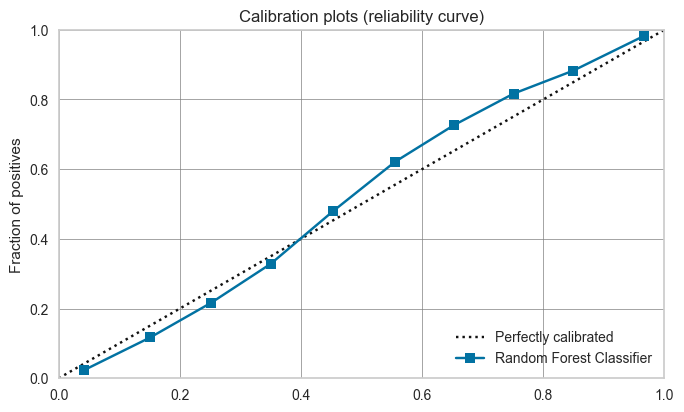

In [ ]:
plot_model(estimator=experiment0_model, plot='calibration')

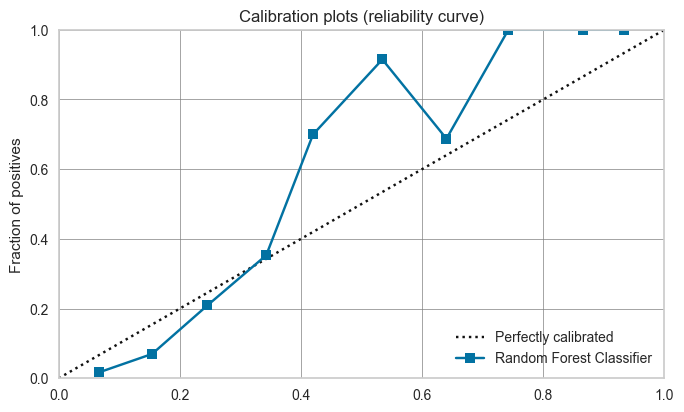

In [ ]:
plot_model(estimator=experiment7_model, plot='calibration')

In [ ]:
experiment0_model_calibrated = experiment0.calibrate_model(estimator=experiment0_model, method='isotonic', return_train_score=True)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
experiment7_model_calibrated = experiment7.calibrate_model(estimator=experiment7_model, method='isotonic', return_train_score=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:36:04
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

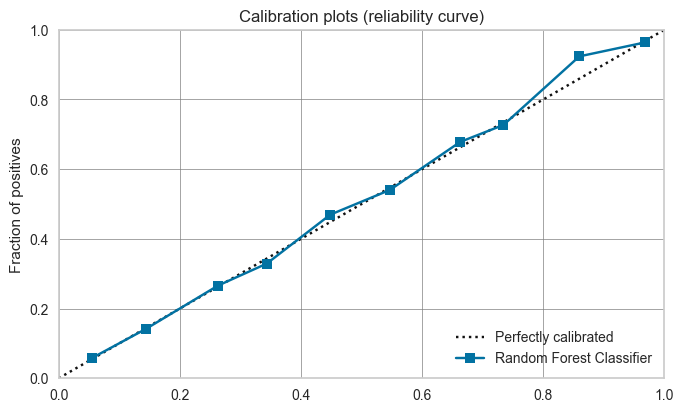

In [ ]:
plot_model(estimator=experiment7_model_calibrated, plot='calibration')

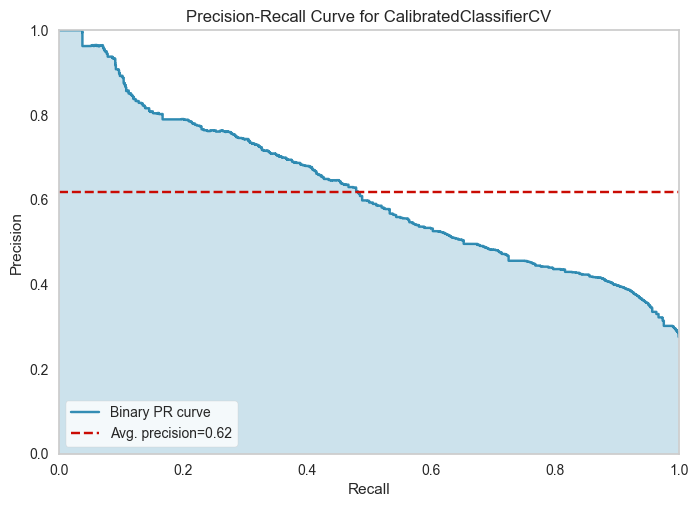

In [ ]:
plot_model(estimator=experiment7_model_calibrated, plot='pr')

Notes:

* roc-auc curve not appropriate?

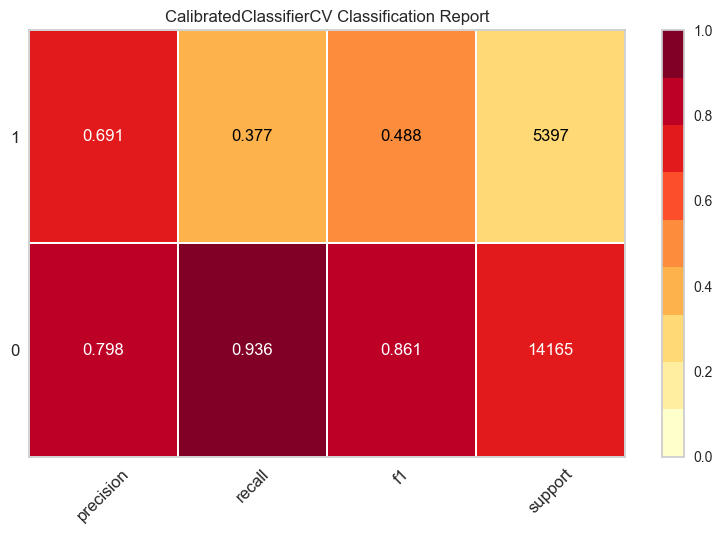

In [ ]:
plot_model(estimator=experiment7_model_calibrated, plot='class_report')

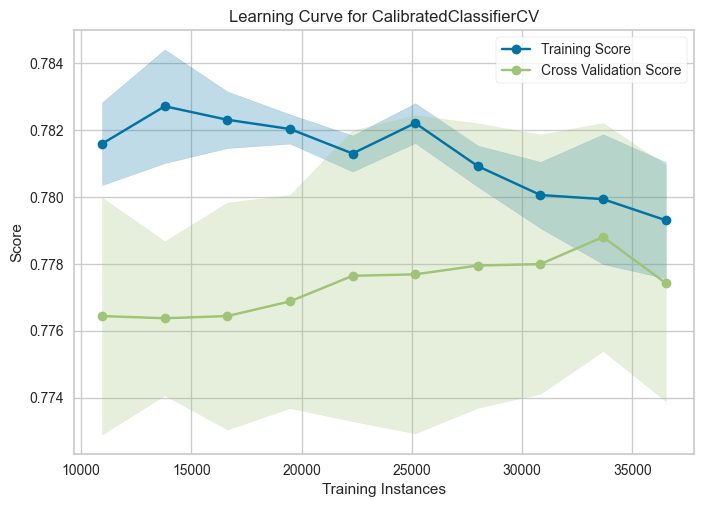

In [ ]:
plot_model(estimator=experiment7_model_calibrated, plot='learning')

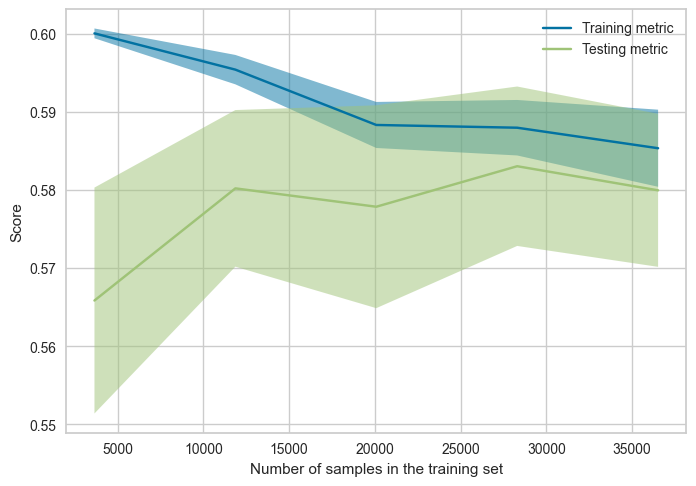

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import LearningCurveDisplay

fbeta_scorer = make_scorer(score_func=fbeta_score, beta=0.5)
X_train_transformed7, y_train_transformed7 = experiment7.get_config('X_train_transformed'), experiment7.get_config('y_train_transformed')

LearningCurveDisplay.from_estimator(estimator=experiment7_model_calibrated, 
                                    X=X_train_transformed7, 
                                    y=y_train_transformed7, 
                                    scoring=fbeta_scorer,
                                    score_type='both')

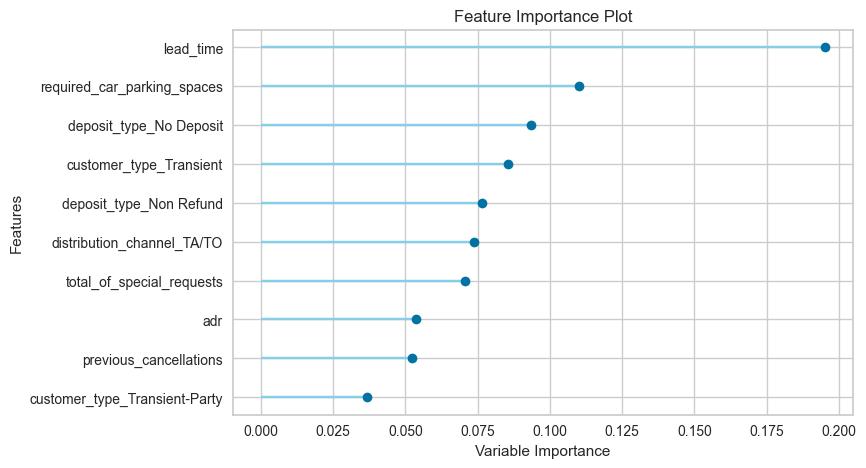

In [ ]:
plot_model(estimator=experiment7_model, plot='feature')

In [ ]:
import dice_ml

X_train_transformed7, X_test_transformed7 = experiment7.get_config('X_train_transformed'), experiment7.get_config('X_test_transformed')
X_train_transformed7['is_canceled'] = experiment7.get_config('y_train')
continuous_features_ = [var for var in numeric_vars.drop(columns=['is_canceled', 'arrival_date_week_number', 'total_stays_in_nights', 
                                                                 'total_guests', 'previous_bookings_not_canceled', 'revenue'])]

dice_data = dice_ml.Data(dataframe=X_train_transformed7, continuous_features=continuous_features_, outcome_name='is_canceled')
dice_model = dice_ml.Model(model=experiment7_model_calibrated, backend='sklearn')
dice_instance = dice_ml.Dice(data_interface=dice_data, model_interface=dice_model, method='kdtree')
dice_explainer = dice_instance.generate_counterfactuals(query_instances=X_test_transformed7[0:1], total_CFs=5)

with pd.option_context('display.max_columns', None):
    dice_explainer.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:30<00:00, 30.75s/it]

Query instance (original outcome : 0)


,lead_time,arrival_date_year,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,4,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,1,3,2,0,0,2,0,0,1,1,0,1,1,0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,1.0,106.0,0,0,0



Diverse Counterfactual set (new outcome: 1)


,lead_time,arrival_date_year,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
13276,-,-,-,-,-,-,-,-,-,0.0,-,-,1.0,-,12.0,-,-,-,-,-,3.0,-,-,0.0,0.0,-,0.0,0.0,1.0,1.0,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,1.0,-,-,-,-,-,-,-,-,-,1.0
19897,14.0,-,-,-,-,-,-,-,1.0,0.0,-,-,-,-,10.0,-,-,-,-,-,1.0,-,-,0.0,0.0,-,-,0.0,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,0.0,-,-,-,1.0
73113,16.0,-,-,-,1.0,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,1.0,-,-,0.0,0.0,1.0,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,0.0,-,-,-,1.0
58095,15.0,-,-,-,-,-,-,-,-,-,-,-,-,-,4.0,-,1.0,-,-,-,1.0,-,-,-,0.0,-,-,0.0,-,-,-,-,-,-,-,-,0.0,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,1.0,0.0,-,-,-,1.0
37904,15.0,-,-,-,-,-,-,-,-,-,-,-,-,-,11.0,-,-,-,-,-,0.0,-,-,0.0,0.0,-,0.0,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,0.0,97.0,-,-,1.0


In [ ]:
# # Defining custom hyperparameter gridspace for 'Naive Bayes'
# parameters = {
#     'var_smoothing': [1e-05, 1e-10]
# }